# Imports

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import random
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from mtranslate import translate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

## Crawling

In [5]:
def data_acquisition(from_page, to_page):
    df = pd.DataFrame(columns=['Car_Type','Price','Year','Hand','CC', 'Kilometers','Color','Gear','Horse_Power'])
    driver = webdriver.Chrome('C:/Users/Mor/Important/cdriver/chromedriver')
    for page in range(from_page,to_page):
        i = 0
        url = 'https://www.yad2.co.il/vehicles/cars?page=' + str(page)
        driver.get(url)
        time.sleep(3)
        wait = WebDriverWait(driver, 10)
        wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        time.sleep(3)
        
        action_chains = ActionChains(driver)
            
        firstLink = driver.find_elements(By.XPATH, '//div[@class="merchant updated_at hasContent"]')
        secondLink = driver.find_elements(By.XPATH, '//div[@class="merchant merchant_name hasContent"]')
        
        for link in firstLink:
            action_chains.move_to_element(link).perform()
            delay = random.uniform(1, 3)
            time.sleep(delay)
            driver.execute_script("arguments[0].click();", link)
            delay = random.uniform(1, 3)
            time.sleep(delay)
        for link in secondLink:
            action_chains.move_to_element(link).perform()
            delay = random.uniform(1, 3)
            time.sleep(delay)
            driver.execute_script("arguments[0].click();", link)
            delay = random.uniform(1, 3)
            time.sleep(delay)

        html_data = driver.page_source
        soup = BeautifulSoup(html_data, 'html.parser')
        wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        time.sleep(3)
        cars_data = soup.find_all("div",class_="feeditem table")

        for car in cars_data:

            car_string = car.find("span", class_="title").text.strip()
            car_type = ''.join([c for c in car_string if c != '(' and c != ')'])
            price = car.find("div", class_="price")
            year = car.find(id="data_year_" + str(i))
            hand = car.find(id="data_hand_" + str(i))
            cc = car.find(id="data_engine_size_" + str(i))
            horse_power_data = car.find("span",class_="subtitle").text
            start_index = horse_power_data.find("(")
            end_index = horse_power_data.find(")")
            horse_power = horse_power_data[start_index + 1:end_index]
            horse_power = ''.join(filter(str.isdigit, horse_power))

            km_arg = car.find(id="more_details_kilometers")
            if(km_arg):
                km = km_arg.find("span")
            else:
                km = None

            color_arg = car.find(id="more_details_color")
            if(color_arg):
                color = color_arg.find("span")
            else:
                color = None

            gear_arg = car.find(id="more_details_gearBox")
            if(gear_arg):
                gear = gear_arg.find("span")
            else:
                gear = None

            i+=1

            # Check if any of the values are None before accessing the .text attribute
            if None in (car_type, price, year, hand, cc, km, color, gear, horse_power):
                continue  # Skip this iteration of the loop

            data_list = [car_type, price.text.strip().replace("₪", ""), year.text.strip(), hand.text.strip(), cc.text.strip(), km.text.strip(), color.text.strip(), gear.text.strip(),horse_power]
            temp_df = pd.DataFrame([data_list], columns=['Car_Type','Price','Year','Hand','CC', 'Kilometers','Color','Gear','Horse_Power'])
            df = df.append(temp_df, ignore_index=True)



    driver.close()
    return df



In [ ]:
carsDF = data_acquisition(1,800)

## Data Handling

In [6]:
def data_translate(df):
    translated_df = df.copy()
    translated_df['Car_Type'] = translated_df['Car_Type'].apply(lambda x: translate(x, 'en', 'he'))
    translated_df['Color'] = translated_df['Color'].apply(lambda x: translate(x, 'en', 'he'))
    translated_df['Gear'] = translated_df['Gear'].apply(lambda x: translate(x, 'en', 'he'))
    return translated_df

In [7]:
def delete_rows_with_more_than_x_words(df, column_name, x):
    # Filter the rows based on the number of words in the column
    filtered_df = df.copy()
    
    filtered_df = filtered_df[(filtered_df[column_name].str.split().apply(len) <= x) | ((filtered_df[column_name].str.split().apply(len) == 3) & (filtered_df[column_name].apply(lambda x: x.split()[1].isdigit())))]
    return filtered_df

In [8]:
regular_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'black', 'white', 'pink', 'orange', 'silver', 'gold', 'gray', 'brown']

def extract_regular_color(color):
    words = color.split()
    for word in words:
        if word in regular_colors:
            return word
    return np.nan

In [9]:
def convert_categorial_numerical(df):
    converted_df = df.copy()
    columns_to_convert = ["Price", "Year", "Hand", "CC", "Kilometers", "Horse_Power"]
    converted_df[columns_to_convert] = converted_df[columns_to_convert].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
    return converted_df

In [10]:
def clean_na_duplicates(df):
    cleaned_df = df.copy()
    cleaned_df = cleaned_df.dropna(axis = 0)
    cleaned_df = cleaned_df.drop_duplicates()
    return cleaned_df

In [11]:
def remove_outliers(cars_data):
    cars_data = cars_data[(cars_data["Year"] <= 2014) | (cars_data["Price"] >= 5000)]
    
    Q1 = np.percentile(cars_data["CC"], 25)
    Q3 = np.percentile(cars_data["CC"], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 6 * IQR
    upper_bound = Q3 + 6 * IQR    
    cars_data = cars_data[(cars_data["CC"] >= lower_bound) & (cars_data["CC"] <= upper_bound)]
    
    return cars_data

In [12]:
def convert_categorial_data(df):
    converted_df = df.copy()
    mapping_gear = {'manually': 0, 'automaton': 1}
    converted_df["Gear"] = converted_df["Gear"].map(mapping_gear)
    converted_df = pd.get_dummies(converted_df)
    return converted_df

In [ ]:
carsDF = data_translate(carsDF)

In [ ]:
carsDF = delete_rows_with_more_than_x_words(carsDF, "Car_Type", 2)
carsDF["Color"] = carsDF["Color"].apply(lambda x: extract_regular_color(x.lower()))
carsDF["Car_Type"] = carsDF["Car_Type"].apply(lambda x: x.lower())

In [ ]:
carsDF = convert_categorial_numerical(carsDF)
carsDF = clean_na_duplicates(carsDF)

In [ ]:
carsDF.to_csv("Project_Cars_Data.csv", index=False)

In [13]:
carsDF = pd.read_csv("Project_Cars_Data.csv")

In [14]:
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,bmw x5,180000,2016,2,1995,110000,white,automaton,231
1,mazda 2,17000,2008,3,1498,137000,gray,automaton,103
2,mazda cx-3,130000,2023,1,1496,250,white,automaton,116
3,kia picanto,76000,2019,1,1248,45600,white,automaton,84
4,hyundai tucson,79000,2017,3,1999,103000,black,automaton,155
...,...,...,...,...,...,...,...,...,...
6753,skoda octavia,103000,2019,1,999,68000,black,automaton,115
6754,bmw 3 series,225000,2019,1,1998,74000,gray,automaton,252
6755,subaru forester,42500,2010,2,1994,300000,gray,automaton,150
6756,subaru forester,82000,2015,2,1995,114000,gray,automaton,150


In [15]:
carsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758 entries, 0 to 6757
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Car_Type     6758 non-null   object
 1   Price        6758 non-null   int64 
 2   Year         6758 non-null   int64 
 3   Hand         6758 non-null   int64 
 4   CC           6758 non-null   int64 
 5   Kilometers   6758 non-null   int64 
 6   Color        6758 non-null   object
 7   Gear         6758 non-null   object
 8   Horse_Power  6758 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 475.3+ KB


In [16]:
# In case of acquisition of overlapping data, we will perform additional cleaning
carsDF = clean_na_duplicates(carsDF)
carsDF.reset_index(drop=True, inplace=True)
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,bmw x5,180000,2016,2,1995,110000,white,automaton,231
1,mazda 2,17000,2008,3,1498,137000,gray,automaton,103
2,mazda cx-3,130000,2023,1,1496,250,white,automaton,116
3,kia picanto,76000,2019,1,1248,45600,white,automaton,84
4,hyundai tucson,79000,2017,3,1999,103000,black,automaton,155
...,...,...,...,...,...,...,...,...,...
6190,skoda octavia,103000,2019,1,999,68000,black,automaton,115
6191,bmw 3 series,225000,2019,1,1998,74000,gray,automaton,252
6192,subaru forester,42500,2010,2,1994,300000,gray,automaton,150
6193,subaru forester,82000,2015,2,1995,114000,gray,automaton,150


C:\Users\Mor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packa

Text(0.5, 1.0, 'CC Box Plot')

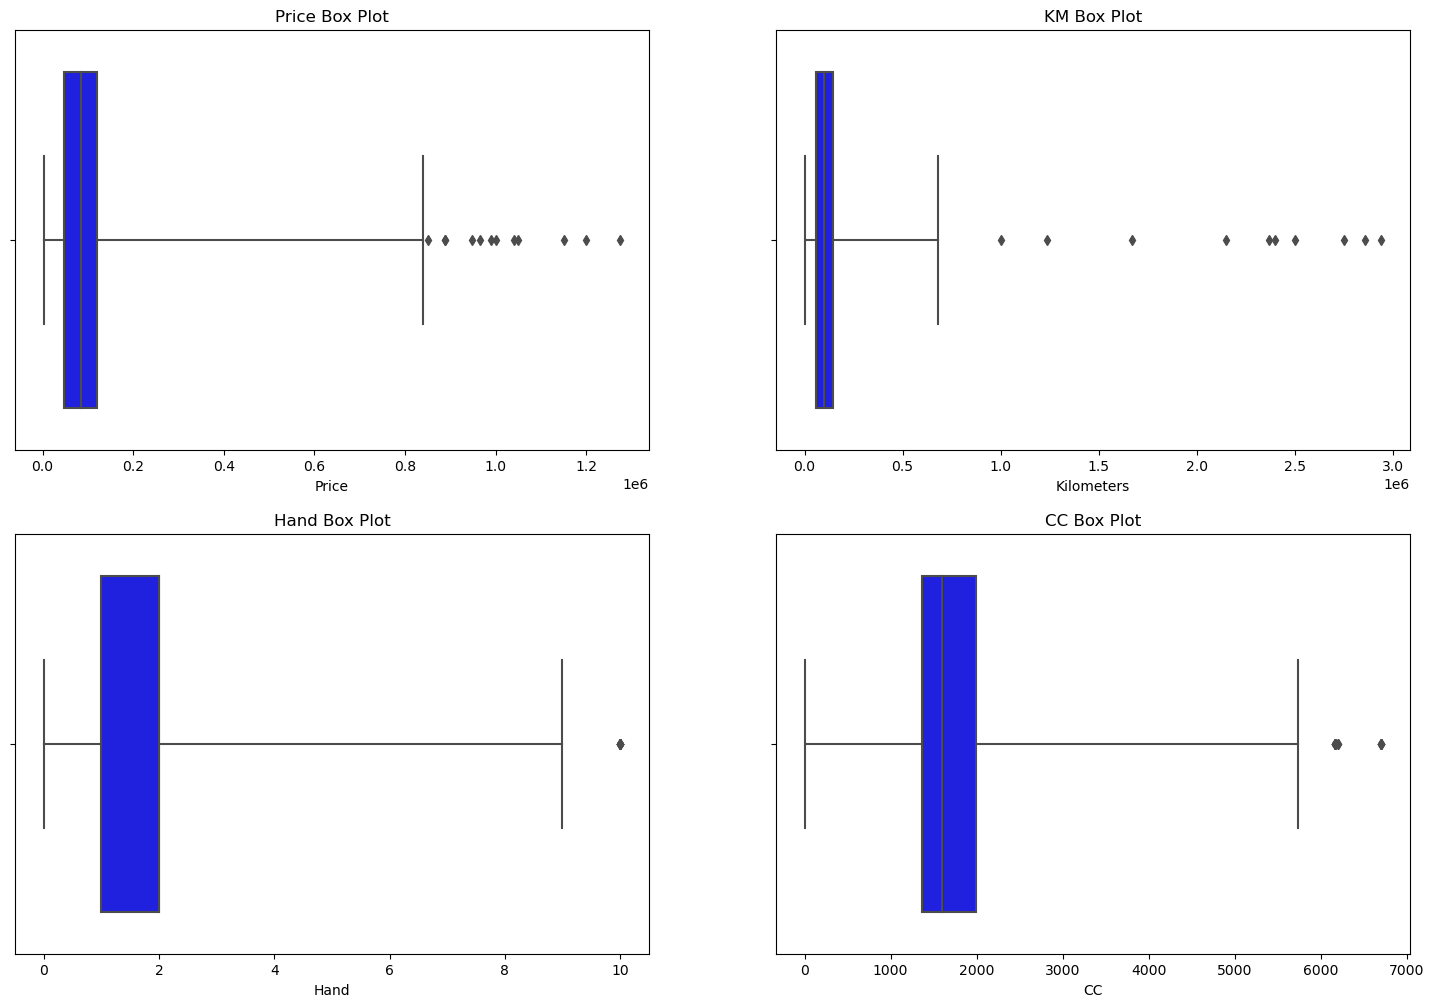

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
sns.boxplot(carsDF["Price"], whis=10, color="blue", ax=axes[0][0])
axes[0][0].set_title('Price Box Plot')
sns.boxplot(carsDF["Kilometers"], whis=7, color="blue", ax=axes[0][1])
axes[0][1].set_title('KM Box Plot')
sns.boxplot(carsDF["Hand"], whis=7, color="blue", ax=axes[1][0])
axes[1][0].set_title('Hand Box Plot')
sns.boxplot(carsDF["CC"], whis=6, color="blue", ax=axes[1][1])
axes[1][1].set_title('CC Box Plot')

In [18]:
carsDF = remove_outliers(carsDF)

In [19]:
carsDF.reset_index(drop=True, inplace=True)
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,bmw x5,180000,2016,2,1995,110000,white,automaton,231
1,mazda 2,17000,2008,3,1498,137000,gray,automaton,103
2,mazda cx-3,130000,2023,1,1496,250,white,automaton,116
3,kia picanto,76000,2019,1,1248,45600,white,automaton,84
4,hyundai tucson,79000,2017,3,1999,103000,black,automaton,155
...,...,...,...,...,...,...,...,...,...
6175,skoda octavia,103000,2019,1,999,68000,black,automaton,115
6176,bmw 3 series,225000,2019,1,1998,74000,gray,automaton,252
6177,subaru forester,42500,2010,2,1994,300000,gray,automaton,150
6178,subaru forester,82000,2015,2,1995,114000,gray,automaton,150


## EDA

<AxesSubplot:>

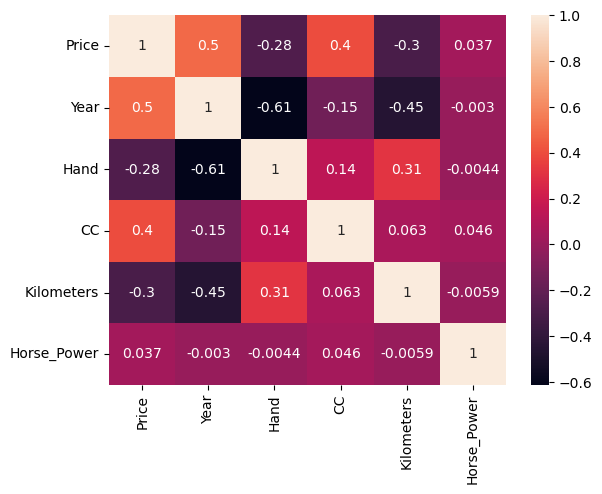

In [20]:
edaDF=pd.DataFrame(carsDF,columns = ['Price','Year','Hand','CC','Kilometers','Horse_Power'])
sns.heatmap(edaDF.corr(), annot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

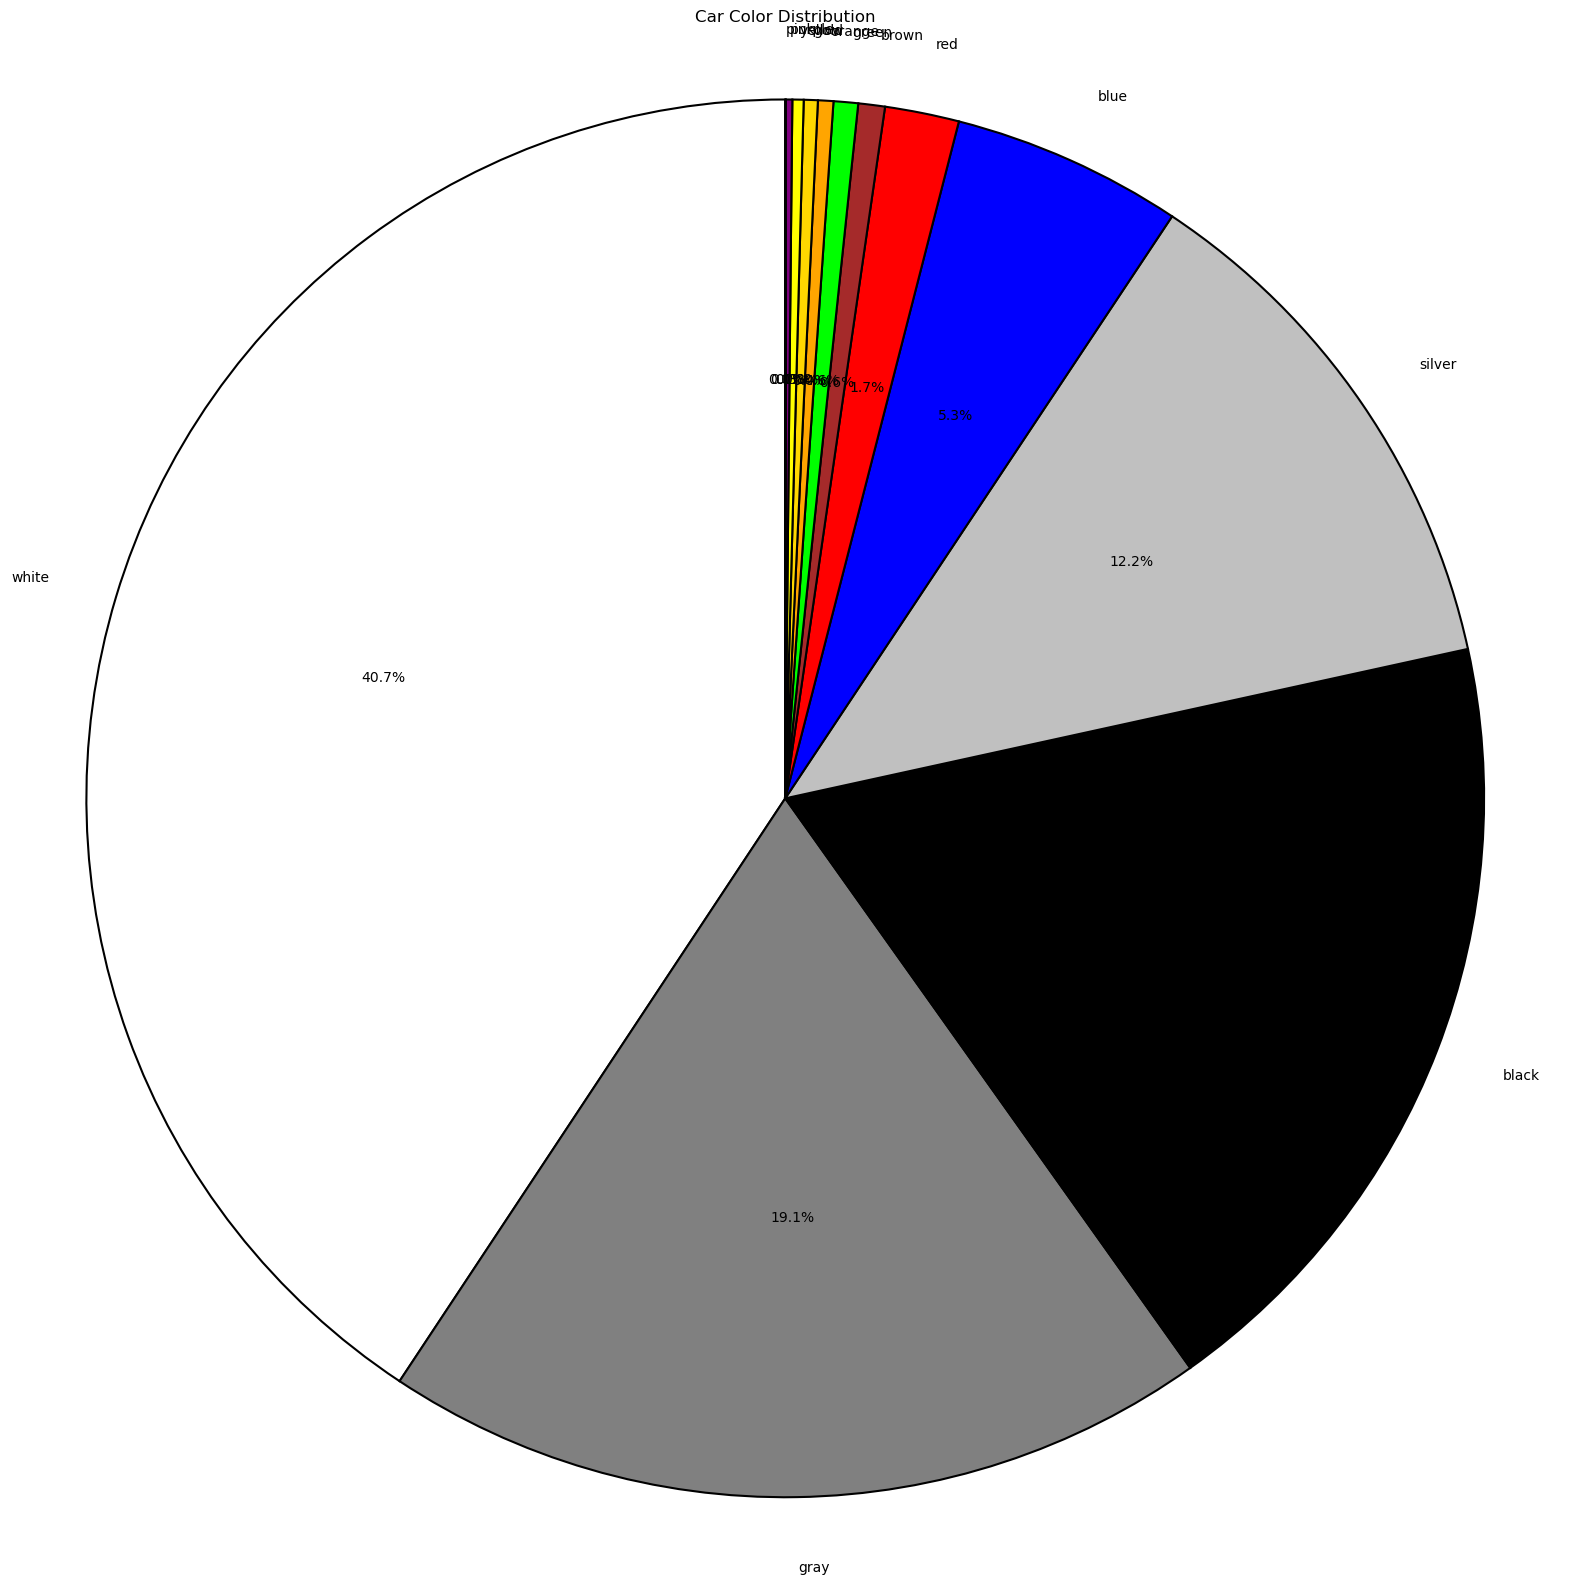

In [21]:
colors = carsDF["Color"]
color_counts = colors.value_counts()
labels = color_counts.index.tolist()
counts = color_counts.tolist()
color_palette = ["#FFFFFF", "#808080", "#000000", "#C0C0C0", "#0000FF","#FF0000", "#A52A2A", "#00FF00", "#FFA500", "#FFD700", "#FFFF00", "#800080", "#FFC0CB"]
plt.figure(figsize = (20,20))
plt.pie(counts, labels=labels, colors=color_palette, autopct="%1.1f%%", startangle=90, wedgeprops = {"edgecolor":"black", "linewidth":1.5})
plt.title("Car Color Distribution")
plt.axis("equal")
plt.show

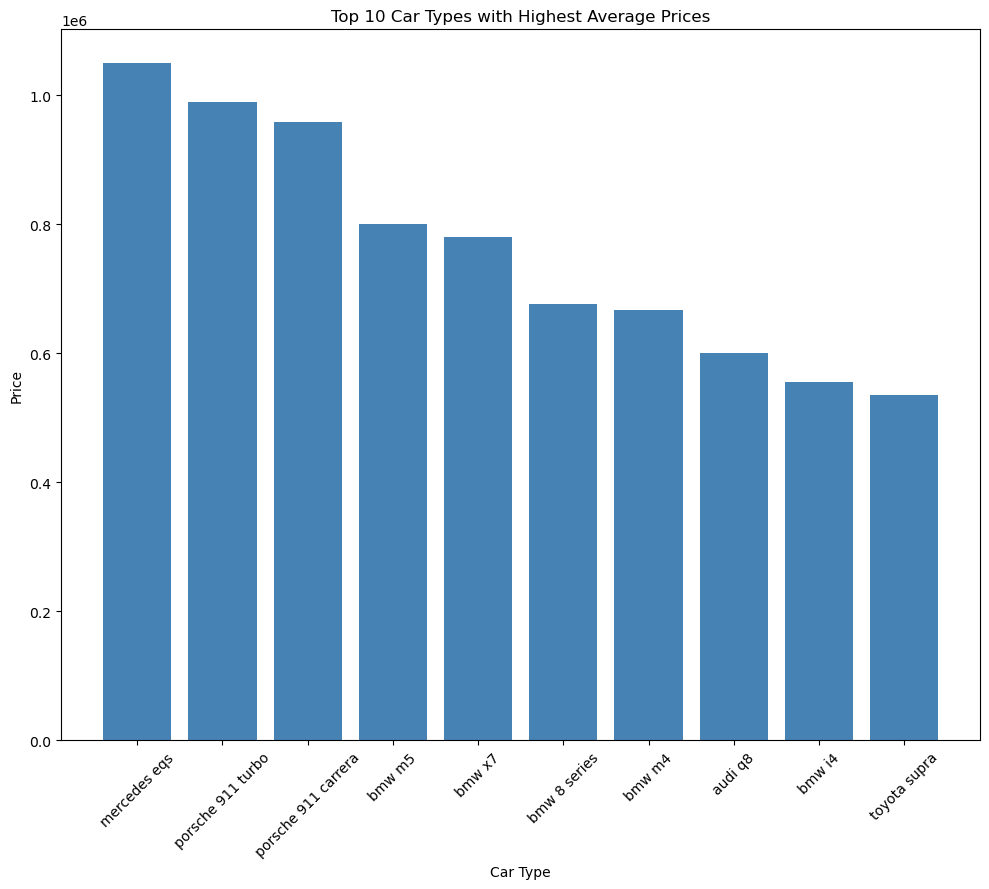

In [22]:
makes = carsDF["Car_Type"]
prices = carsDF["Price"]
avg_prices = carsDF.groupby("Car_Type")["Price"].mean()
sorted_avg_prices = avg_prices.sort_values(ascending=False)
top_makes = sorted_avg_prices.head(10)

plt.figure(figsize=(10, 9))
plt.bar(top_makes.index, top_makes.values, color="steelblue")
plt.xlabel("Car Type")
plt.ylabel("Price")
plt.title("Top 10 Car Types with Highest Average Prices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

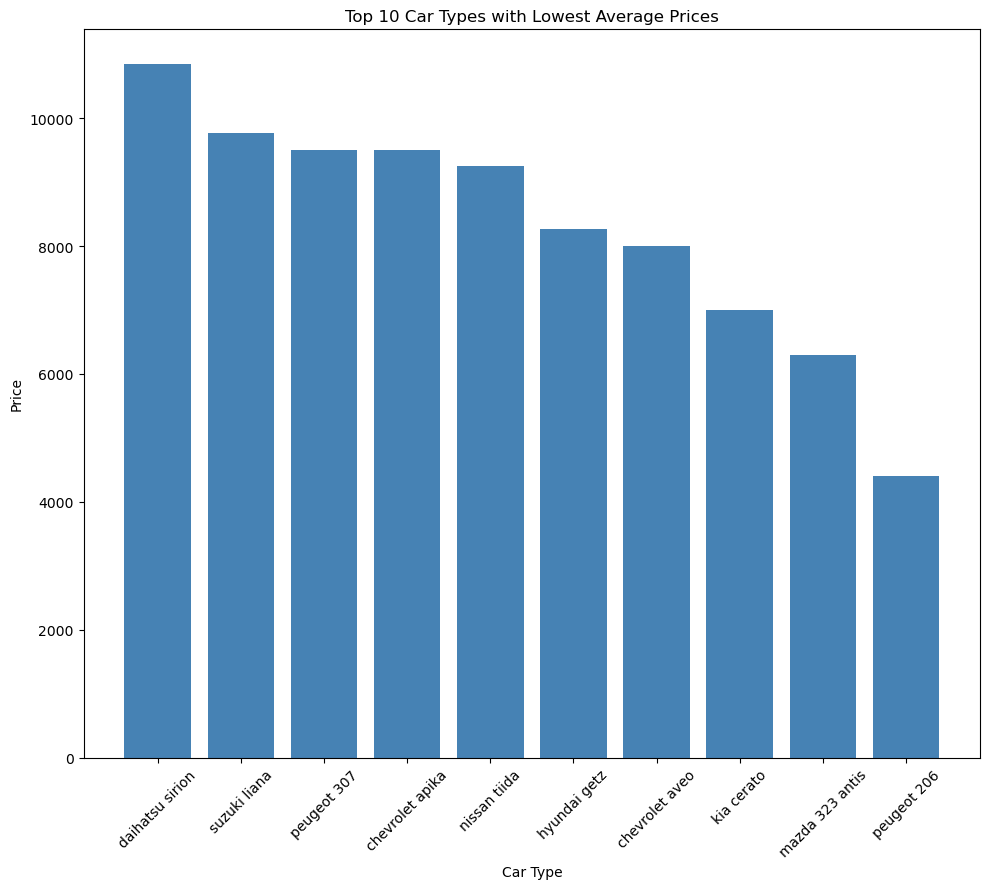

In [23]:
makes = carsDF["Car_Type"]
prices = carsDF["Price"]
avg_prices = carsDF.groupby("Car_Type")["Price"].mean()
sorted_avg_prices = avg_prices.sort_values(ascending=False)
top_makes = sorted_avg_prices.tail(10)

plt.figure(figsize=(10, 9))
plt.bar(top_makes.index, top_makes.values, color="steelblue")
plt.xlabel("Car Type")
plt.ylabel("Price")
plt.title("Top 10 Car Types with Lowest Average Prices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

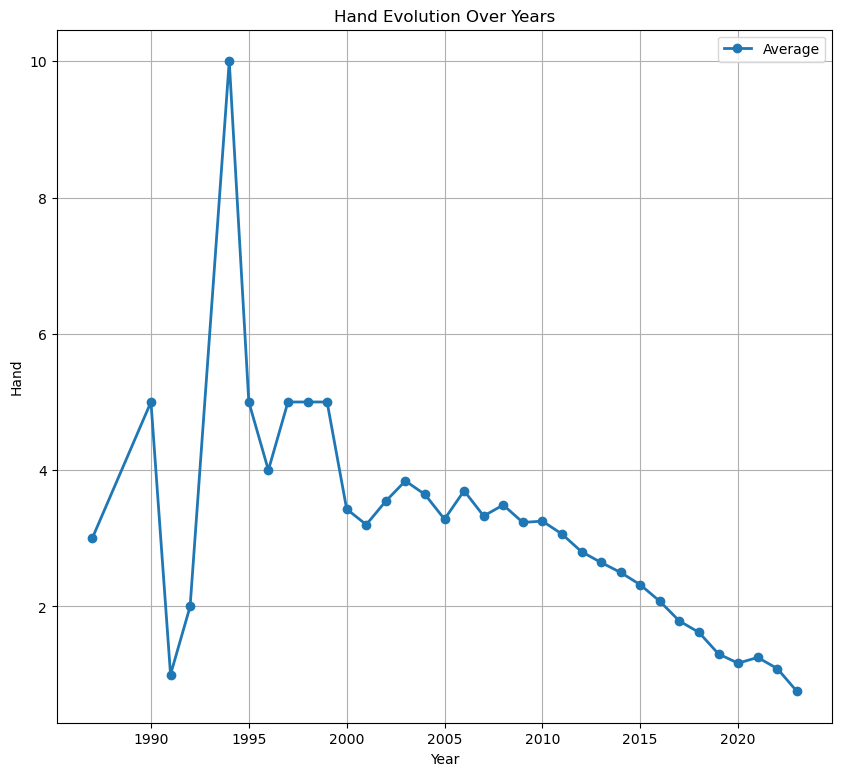

In [24]:
avg_hand_by_year = carsDF.groupby("Year")["Hand"].mean()
plt.figure(figsize=(10,9))
# plt.scatter(carsDF["Year"], carsDF["Hand"], s=50, alpha=0.5)
plt.plot(avg_hand_by_year.index, avg_hand_by_year.values, marker = 'o', linestyle='-', linewidth = 2, label="Average")
plt.xlabel("Year")
plt.ylabel("Hand")
plt.title("Hand Evolution Over Years")
# plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show

## Machine Learning

In [25]:
# Preparation for machine learning
carsDF = convert_categorial_data(carsDF)
carsDF

,Price,Year,Hand,CC,Kilometers,Gear,Horse_Power,Car_Type_595 eberth,Car_Type_audi a1,Car_Type_audi a3,...,Color_gold,Color_gray,Color_green,Color_orange,Color_pink,Color_purple,Color_red,Color_silver,Color_white,Color_yellow
0,180000,2016,2,1995,110000,1,231,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,17000,2008,3,1498,137000,1,103,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,130000,2023,1,1496,250,1,116,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,76000,2019,1,1248,45600,1,84,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,79000,2017,3,1999,103000,1,155,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,103000,2019,1,999,68000,1,115,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6176,225000,2019,1,1998,74000,1,252,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6177,42500,2010,2,1994,300000,1,150,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6178,82000,2015,2,1995,114000,1,150,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
X = carsDF.drop("Price", axis=1)
y = carsDF["Price"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 1954631264.1625724
R^2 Score: 0.7872586304748442


In [31]:
successDF = pd.DataFrame({"real_data":y_test, "predicted_data":y_pred})
successDF

,real_data,predicted_data
3691,155000,163636.681155
969,89000,170817.935360
2450,47000,64331.773644
3082,135000,159498.415988
3727,82000,95442.595813
...,...,...
5716,53000,50747.125231
1606,57900,74437.381435
5735,38000,34750.217940
5996,154000,151761.112033


In [32]:
successDF.to_csv("predicteddata.csv", index=False)